<h1>Naive analysis of 1I/2017 U1 (ʻOumuamua) MPC magnitude observations</h1>

Data from MPC: https://www.minorplanetcenter.net/db_search/show_object?utf8=%E2%9C%93&object_id=A%2F2017+U1

- [MPEC 2017-U265](https://www.minorplanetcenter.net/mpec/K17/K17UQ5.html)
- [MPEC 2017-U263](https://www.minorplanetcenter.net/mpec/K17/K17UQ3.html)
- [MPEC 2017-U183](https://www.minorplanetcenter.net/mpec/K17/K17UI3.html)
- [MPEC 2017-U181](https://www.minorplanetcenter.net/mpec/K17/K17UI1.html)
- [MPEC 2017-V01](http://minorplanetcenter.net/mpec/K17/K17V01.html)


DISCLAIMER: this is experimental code and the results drawn will be inconclusive due to unknown uncertainties in the input data and the nature of the magnitude measurements reported to the MPC. See for example the discussion below:

> https://groups.yahoo.com/neo/groups/mpml/conversations/topics/33263

The intention here is to perform a naive analysis anyway in order to:

- compare results to future light curves produced with higher quality methods (for example: https://arxiv.org/abs/1711.01402)
- improve own skills and methods to be applied to other datasets
    
So, let's see if we can say something about the object's rotation period using the reported magnitudes to the MPC.


We begin by importing some auxiliary functions and setting some general values

In [1]:
%matplotlib inline
%run functions.py

asteroidHorizonsName = 'A/2017 U1' # current denomination for the object in JPL Horizons

The MPC data for ʻOumuamua can be automatically retrieved from the web, but a direct link to the text format does not seem to exist. Instead, a <a href="https://www.minorplanetcenter.net/db_search/show_object?utf8=%E2%9C%93&object_id=A%2F2017+U1">db search</a> must be done first so that the data is cached in the temp url below.

Just in case, the data has been stored to a text file in this repository, therefore we set useWebInput to False and get our <a href="a2017u1_mpc.txt">own copy of the data</a>.

We do a parse of fixed size data with the Pandas package

In [2]:
useWebInput = False

lightcurveSourceFile = 'https://www.minorplanetcenter.net/tmp/A_2017_U1.txt' if useWebInput else 'a2017u1_mpc.txt'

mpcData = pd.read_fwf(lightcurveSourceFile,
    header = None,
    widths = [13, 1, 1, 16, 12, 12, 10, 5, 1, 6, 3],
    usecols= [1, 2, 3, 7, 8, 9, 10],
    names = ['note1', 'note2', 'decimalDaytime', 'mag', 'band', 'blank', 'observatory']
)

In [3]:
mpcData[:3]  # show the first 3 lines

#mpcData.to_csv('a2017u1.csv')  #uncomment this line to save the data in csv format

,note1,note2,decimalDaytime,mag,band,blank,observatory
0,NaN,C,2017 10 14.43936,19.0,G,U@6548,703
1,NaN,C,2017 10 17.37391,19.5,G,U@6548,703
2,NaN,C,2017 10 18.47298,19.8,w,L@6548,F51


The current MPC time format is not friendly to other Python packages. We add some auxiliary columns with observation times in different useful formats. 

In [4]:
data = mpcData

data['time'] = data.decimalDaytime.apply(timeFromDecimalDaytime)
data['when'] = data.apply(lambda row: row.time.datetime.strftime('%Y-%b-%d %H:%M:%S'), axis=1)
data['timestamp'] = data.apply(lambda row: row.time.jd, axis=1)
data['date'] = data.apply(lambda row: row.time.datetime.strftime('%Y-%m-%d'), axis=1)

data[:3]

,note1,note2,decimalDaytime,mag,band,blank,observatory,time,when,timestamp,date
0,NaN,C,2017 10 14.43936,19.0,G,U@6548,703,2017-10-14T10:32:40.000,2017-Oct-14 10:32:40,2.458041e+06,2017-10-14
1,NaN,C,2017 10 17.37391,19.5,G,U@6548,703,2017-10-17T08:58:25.000,2017-Oct-17 08:58:25,2.458044e+06,2017-10-17
2,NaN,C,2017 10 18.47298,19.8,w,L@6548,F51,2017-10-18T11:21:05.000,2017-Oct-18 11:21:05,2.458045e+06,2017-10-18


Now we focus on the magnitude values. Since ʻOumuamua was travelling fast during the MPC observations, its magnitude varied correspondingly. We use JPL Horizons to get a baseline magnitude that we can "normalize" all observations against.

In [5]:
if False: # this block would retrieve magnitudes from JPL directly, but the callhorizons package could not retrieve data for this object at the time of writing
    dateList = data.date.unique()
    intervals = getHorizonsIntervalsForDates(dateList)
    ephemerides = pd.DataFrame()

    for interval in intervals:
        ephemerides = pd.concat([ephemerides,
            getReferenceMagnitudesFromHorizons(asteroidHorizonsName, interval[0], interval[1])
            ])

# we read the JPL magnitude values from a manually fetched file instead
ephemerides = pd.read_fwf(
    'A2017U1_horizons.txt',
    widths=[22, 25, 6, 19, 10, 9, 5, 6],
    usecols=[0, 2],
    names=['date', 'APmag'])

We match each observation to a reference apparent magnitude from JPL Horizons for the nearest hour and calculate a magnitude delta.

In [6]:
def APmagFromEphemerides(eph):
    row = ephemerides.loc[ephemerides['date'] == (eph[0:15] + '00')].iloc[0]
    return float(row.APmag)

data['APmag'] = data.apply(lambda row: APmagFromEphemerides(row.when), axis=1)
data['magDelta'] = data.apply(lambda row: row.mag - row.APmag, axis=1)

data[:3]

,note1,note2,decimalDaytime,mag,band,blank,observatory,time,when,timestamp,date,APmag,magDelta
0,NaN,C,2017 10 14.43936,19.0,G,U@6548,703,2017-10-14T10:32:40.000,2017-Oct-14 10:32:40,2.458041e+06,2017-10-14,20.12,-1.12
1,NaN,C,2017 10 17.37391,19.5,G,U@6548,703,2017-10-17T08:58:25.000,2017-Oct-17 08:58:25,2.458044e+06,2017-10-17,19.64,-0.14
2,NaN,C,2017 10 18.47298,19.8,w,L@6548,F51,2017-10-18T11:21:05.000,2017-Oct-18 11:21:05,2.458045e+06,2017-10-18,19.64,0.16


Let's now plot a curve for the apparent magnitude and compare with the MPC observations.

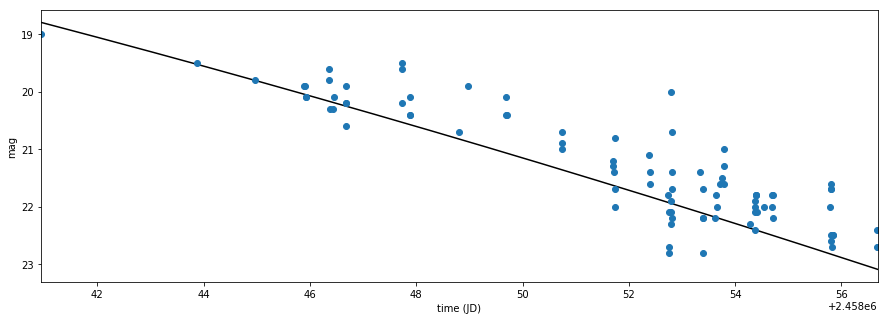

In [7]:
xs = [pd.to_datetime(d) for d in data.when]

import numpy.polynomial.polynomial as poly
ts = data.timestamp
coefs = poly.polyfit(ts, data.APmag, 2)
x_new = np.linspace(ts[0], ts[len(ts) - 1], num=len(ts)*10)
ffit = poly.Polynomial(coefs)


plt.rcParams['figure.figsize'] = (15, 5)
plt.plot(x_new, ffit(x_new), color='k', lw=1.5, zorder=1)
plt.scatter(ts, data.mag, zorder=2)
plt.xlim(ts[0], ts[len(ts) - 1])
plt.xlabel('time (JD)')
plt.ylabel('mag')
plt.gca().invert_yaxis();


As noted in later research literature, the object appears to be brighter than what could be expected. There is also variability, which hints at noticeable rotation, but the magnitude observations in play here vary in reported bands, so let's see if we can narrow down the effects.

First, a clearer plot of all the magnitudes:


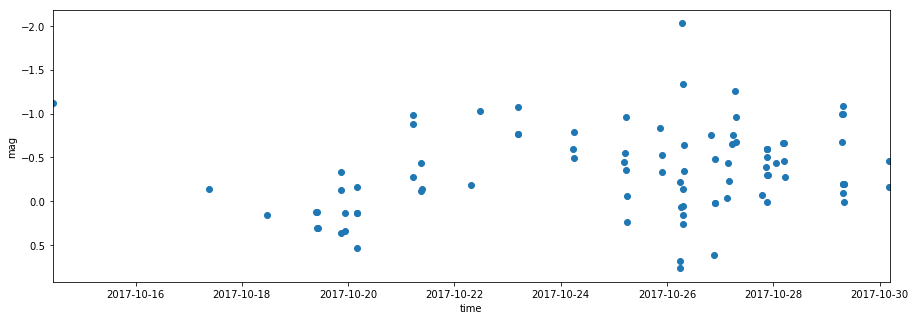

In [8]:
# auxiliary function to plot "normalized" magnitudes
def plotMagDeltas(observations):
    xs = [pd.to_datetime(d) for d in observations.when]

    plt.rcParams['figure.figsize'] = (15, 5);
    plt.scatter(xs, observations.magDelta);
    plt.xlim(xs[0], xs[len(xs) - 1]);
    plt.xlabel('time')
    plt.ylabel('mag')
    plt.gca().invert_yaxis();
    

# let's work with all data first
relevantObservations = data

# an example of filtering out observations depending on time
#relevantObservations = data.loc[data['timestamp'] > 1.508406e+09]
#relevantObservations.reset_index(inplace=True)

plotMagDeltas(relevantObservations)

Now we apply a naive Lomb-Scargle periodogram. Naive, because we don't do any advanced tuning. We use a Nyquist factor that replicated the Lomb results of a dataset from an unrelated research paper (see <a href="Thirouin et al.ipynb">appendix notebook</a>)

Best frequency (cycles per day) =  0.00635008830601
Best period (hours) =  3779.47499994


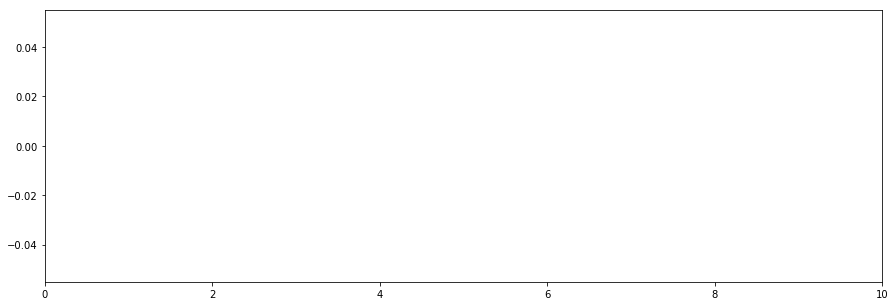

In [9]:
from astropy.stats import LombScargle
import astropy.units as u

# auxiliary function to plot a naive Lomb periodogram
def naiveLombScargle(observations):
    a = observations.timestamp.values
    startTimestamp = a[0]
    a = a - a[0]

    b = observations.magDelta.values
    freq, power = LombScargle(a, b).autopower(nyquist_factor=100)

    plt.rcParams['figure.figsize'] = (15, 5);
    plt.figure();
    plt.plot(1/freq, power);
    plt.xlim(0,10);

    best_frequency = freq[np.argmax(power)]

    print('Best frequency (cycles per day) = ', best_frequency)
    print('Best period (hours) = ', (1/best_frequency) * 24)
    
    #t_fit = np.linspace(0*u.hour,1000*u.hour)
    #y_fit = LombScargle(a, b).model(t_fit, best_frequency)
    
    #plt.plot(y_fit);
    
    return freq,power
    
naiveLombScargle(relevantObservations);

Nothing here, the magnitudes coming from different bands and telescopes are too heteregoneous. Let's see if we filter by the R band, which is the one with the highest number of observations.

Best frequency (cycles per day) =  34.9700606279
Best period (hours) =  0.686301355189


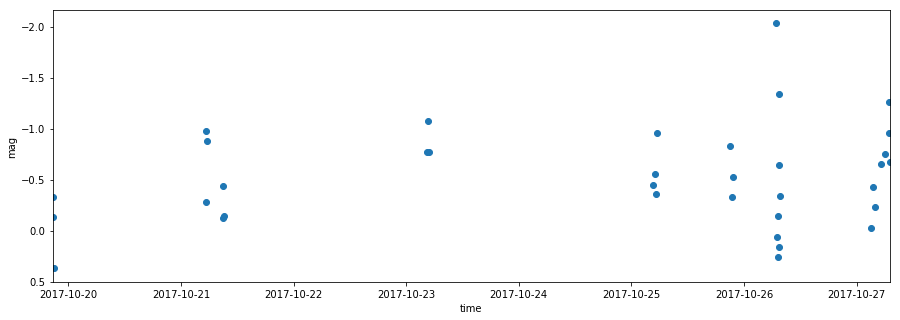

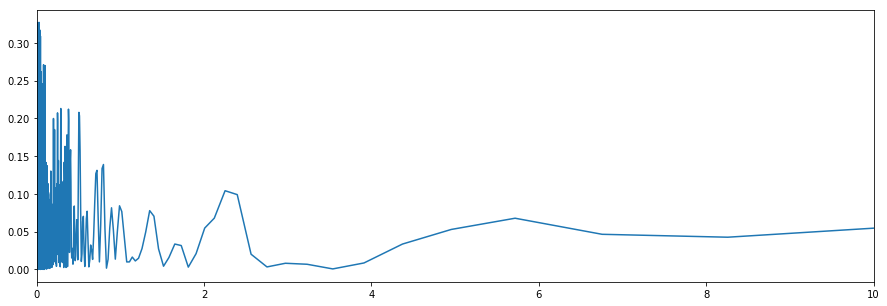

In [10]:
relevantObservations = data[(data.band == 'R')]
plotMagDeltas(relevantObservations)
freq, power = naiveLombScargle(relevantObservations)


Still not good, a consequence of mixing telescopes and observations of varying quality. Let's limit to the telescope with the most observations instead (926 - Tenagra II) 

Best frequency (cycles per day) =  5.69446019905
Best period (hours) =  4.21462248591


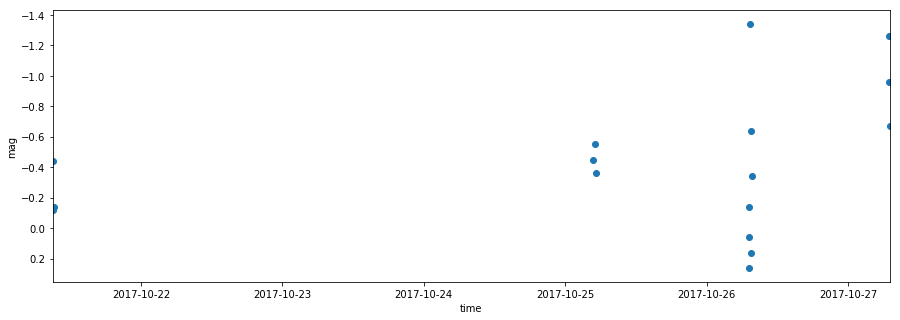

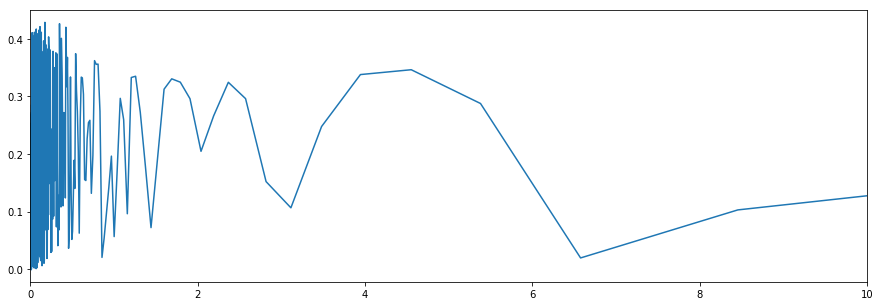

In [11]:
relevantObservations = data[(data.band == 'R') & (data.observatory == '926')]
plotMagDeltas(relevantObservations)
freq, power = naiveLombScargle(relevantObservations)

This looks better, how about the G band (the second most reported band)?

Best frequency (cycles per day) =  4.76891631782
Best period (hours) =  5.03258988008


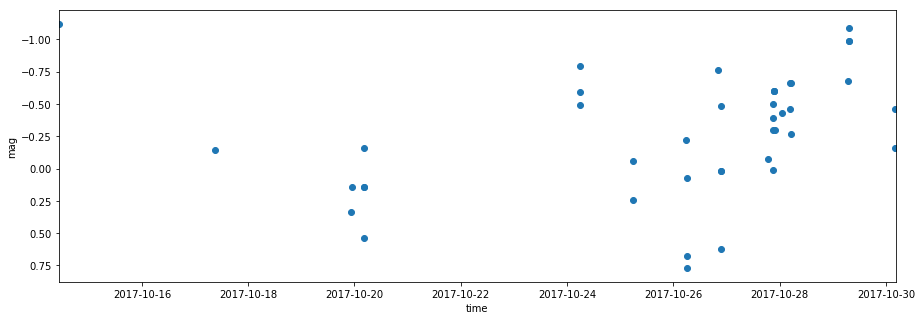

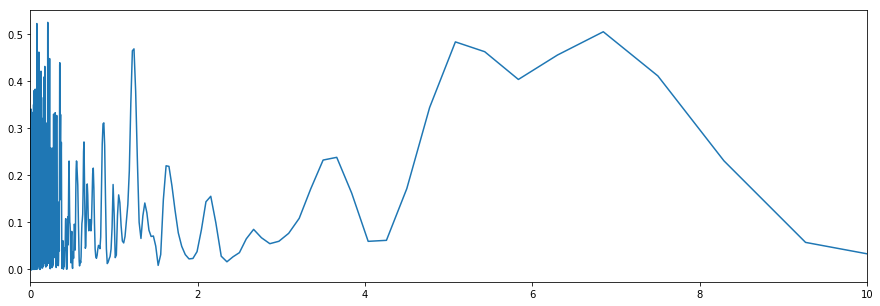

In [12]:
gBandObservations = data[(data.band == 'G')]
plotMagDeltas(gBandObservations)
freq, power = naiveLombScargle(gBandObservations)


and let's see what we get for the Apache Point observations, later used in <a href="https://arxiv.org/abs/1711.04927">this paper by Bolin et al</a>

Best frequency (cycles per day) =  7828.06945339
Best period (hours) =  0.00306589001834


,note1,note2,decimalDaytime,mag,band,blank,observatory,time,when,timestamp,date,APmag,magDelta
100,$,C,2017 10 29.30331,22.6,r,t@6549,705,2017-10-29T07:16:45.000,2017-Oct-29 07:16:45,2.458056e+06,2017-10-29,22.69,-0.09
102,$,C,2017 10 29.30993,22.5,r,t@6549,705,2017-10-29T07:26:17.000,2017-Oct-29 07:26:17,2.458056e+06,2017-10-29,22.69,-0.19
104,$,C,2017 10 29.31669,22.5,r,t@6549,705,2017-10-29T07:36:02.000,2017-Oct-29 07:36:02,2.458056e+06,2017-10-29,22.69,-0.19
105,$,C,2017 10 29.32845,22.7,r,t@6549,705,2017-10-29T07:52:58.000,2017-Oct-29 07:52:58,2.458056e+06,2017-10-29,22.69,0.01
106,$,C,2017 10 29.33510,22.5,r,t@6549,705,2017-10-29T08:02:32.000,2017-Oct-29 08:02:32,2.458056e+06,2017-10-29,22.70,-0.20
107,$,C,2017 10 29.33730,22.5,r,t@6549,705,2017-10-29T08:05:42.000,2017-Oct-29 08:05:42,2.458056e+06,2017-10-29,22.70,-0.20


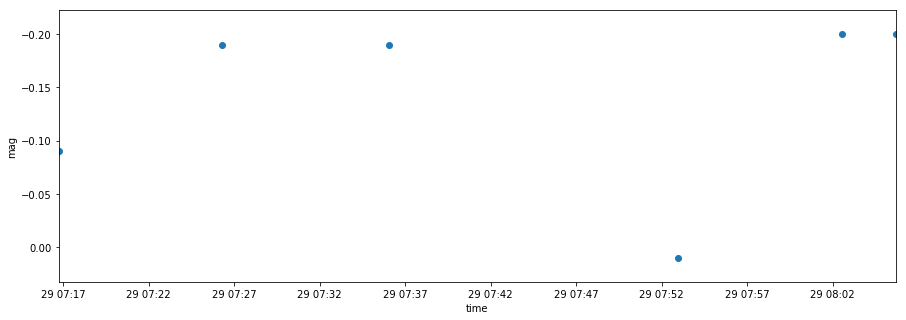

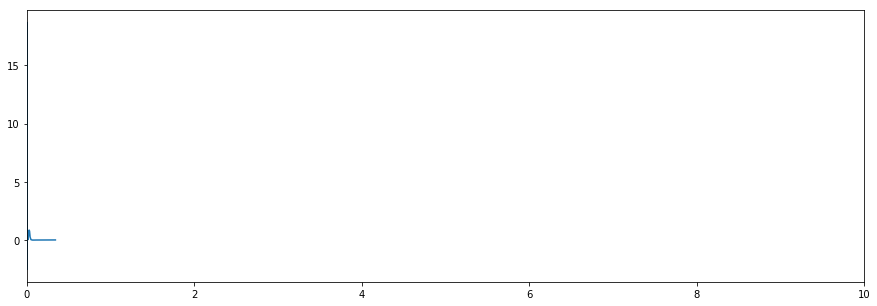

In [13]:
apachePointObservations = data[(data.observatory == '705')]
plotMagDeltas(apachePointObservations)
freq, power = naiveLombScargle(apachePointObservations)
apachePointObservations


Well, nothing! But: there are only 6 data points in the MPC, while the paper shows 12 (alongside other data points from the DCT observatory from <a href="https://arxiv.org/ftp/arxiv/papers/1711/1711.01402.pdf">this Knight et al paper</a>. The aggregated data is available in an <a href="https://github.com/dhuppenkothen/CometPeriodSearch">ancillary github repository</a>, so the next step is to reproduce those results in a different notebook along with other reported observations from additional ʻOumuamua research papers and see if a total lightcurve can be obtained. Stay tuned!